# Phenotyping

The first part of this notebook is based on code originally published with the paper by Kuett et al. (2022): [model201710_model_analyse_single_cells.ipynb](https://github.com/BodenmillerGroup/3D_IMC_publication/blob/main/Python/scripts/single_cell_analysis/model201710_model_analyse_single_cells.ipynb). It was modified to execute phenograph clustering only.

In the second part of the notebook, custom phenotype labels (mainly based on original clustering results from the first part) are assigned, which was not done in the original publication.

In [1]:
## Imports
import scanpy as sc
import numpy as np
import pandas as pd
import phenograph
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## File paths
input_base = "../../data/Kuett_2022/MainHer2BreastCancerModel/"
measurements = input_base + 'model201710_mean_intensities.csv'
lable_annotation = input_base + 'model201710_labels_area.csv'

In [3]:
## Load data
adata = sc.read_csv(measurements)
extra_annotation = pd.read_csv(lable_annotation)
adata.obs['cell_labels'] = list(extra_annotation['label'])
adata.obs['cell_labels'] = adata.obs['cell_labels'].astype('category')
adata.obs['cell_volume'] = list(extra_annotation['area'])
adata.obs['cell_volume'] = adata.obs['cell_volume'].astype('int64')

In [9]:
adata ## data structure

AnnData object with n_obs × n_vars = 108486 × 25
    obs: 'cell_labels', 'cell_volume'

In [ ]:
## Range normalization to the 99th percentile
# across all cells, for each channel separately
max_each_var = np.percentile(adata.X, 99, axis = 0)
min_each_var = np.min(adata.X,0)
range_var = max_each_var - min_each_var
adata.X = adata.X - min_each_var
adata.X = np.divide(adata.X, range_var)
adata.X[adata.X>1] = 1

sc.pp.neighbors(adata, n_neighbors=10,random_state = 111)
sc.tl.umap(adata,random_state = 111)
#adata.write(results_file)

/home/gesa/.py_venv/phenograph/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
adata ## data structure

AnnData object with n_obs × n_vars = 108486 × 25
    obs: 'cell_labels', 'cell_volume'
    uns: 'neighbors', 'umap'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [ ]:
## Phenograph clustering
# Since this is not replicable (despite seed),
# skip this step and load the results below
communities, graph, Q = phenograph.cluster(adata.X, k=10, primary_metric= 'manhattan', seed = 10)
print(np.unique(communities))

Finding 10 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 49.71676182746887 seconds
Jaccard graph constructed in 3.3068535327911377 seconds
Wrote graph to binary file in 0.3313634395599365 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.867816
After 3 runs, maximum modularity is Q = 0.869564
Louvain completed 23 runs in 28.383280038833618 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 82.40377998352051 seconds
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36]


In [46]:
np.unique(communities) ## cluster labels

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36])

In [ ]:
## Recode cluster 0 to a new cluster number
# reason unclear, not documented in the paper
largest = max(np.unique(communities))+1
communities = [largest if x == 0 else x for x in communities]
adata.obs['phenograph'] = pd.Categorical(communities)
np.unique(communities) # cluster labels

array([-1,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37])

In [51]:
adata ## data structure

AnnData object with n_obs × n_vars = 108486 × 25
    obs: 'cell_labels', 'cell_volume', 'phenograph'
    uns: 'neighbors', 'umap', 'dendrogram_phenograph'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [11]:
## Save cluster labels to file
outfile = '../../data/phenotyping_cluster_labels_phenograph.csv'
adata.obs[['cell_labels', 'phenograph']].to_csv(outfile, index=False)

## Phenotyping beyond Kuett et al. (2022)

In [ ]:
## Load data from file if previously saved
# to conserve cluster labels
infile = '../../data/phenotyping_cluster_labels_phenograph.csv'
adata.obs = pd.merge( adata.obs, pd.read_csv(infile),
            how='left', on='cell_labels')
adata.obs['phenograph'] = adata.obs['phenograph'].astype('category')
adata.obs.rename({'cell_labels':'id'}, axis=1, inplace=True)

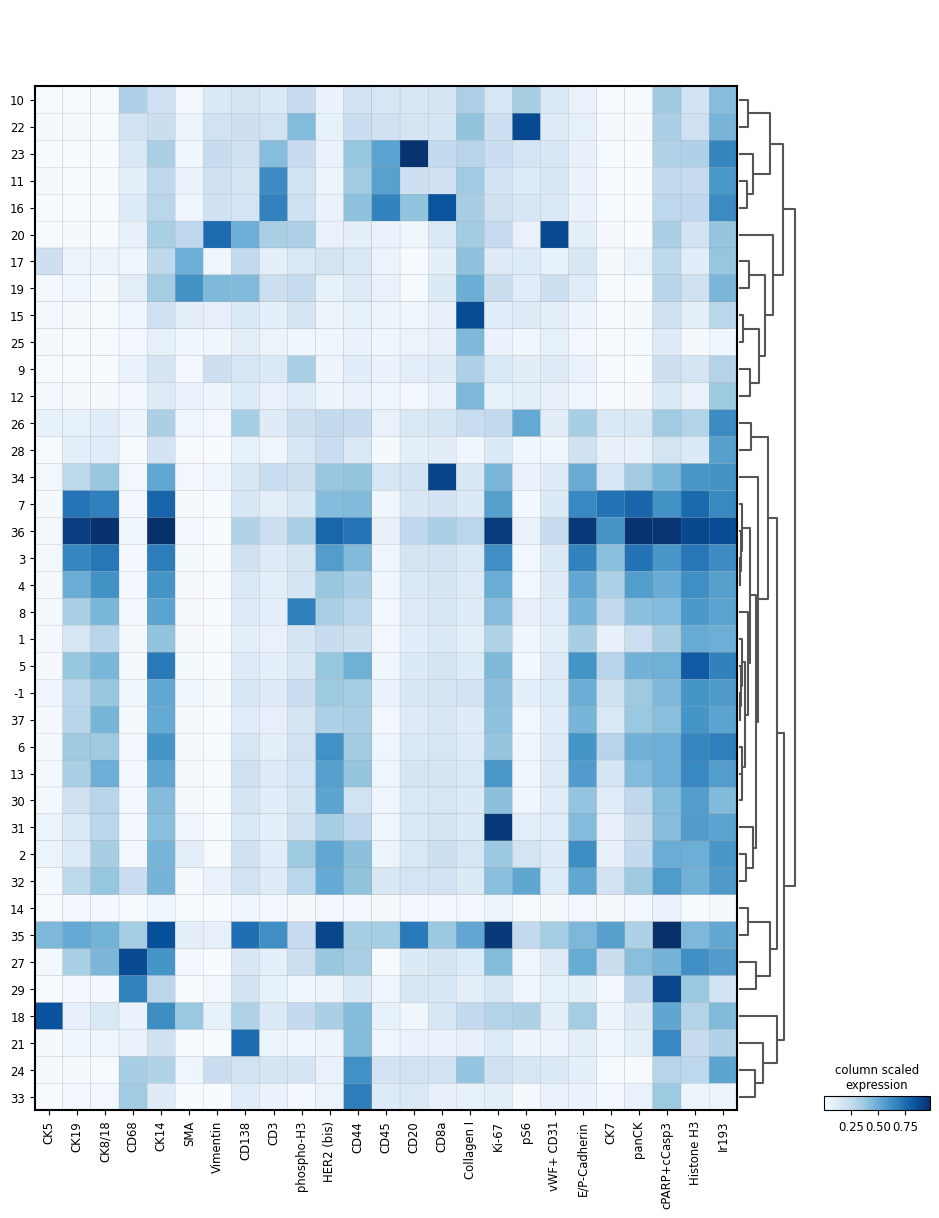

In [22]:
## Plot (as in Fig. 3a)
sc.tl.dendrogram(adata, groupby='phenograph') # prerequisite for plotting
sc.pl.matrixplot(adata,adata.var_names, 'phenograph', dendrogram=True, cmap='Blues', 
                 colorbar_title='column scaled\nexpression')

/tmp/ipykernel_56478/1423080586.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = pd.DataFrame({ 'n_cells': adata.obs.groupby('phenograph').size() })


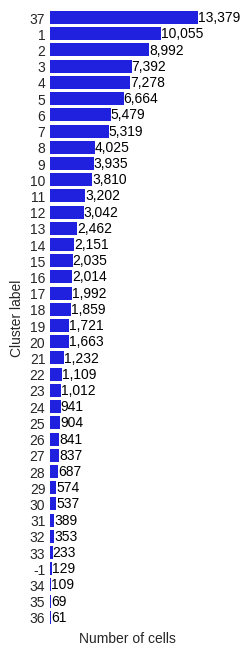

In [23]:
## Get number of cells per cluster (as in Fig. 3a)
counts = pd.DataFrame({ 'n_cells': adata.obs.groupby('phenograph').size() })
counts.index.name = 'phenotype'
counts.sort_values('n_cells', ascending=False, inplace=True)

# Barplot with ('true') 3D counts
with plt.style.context('seaborn-v0_8-whitegrid'):
    plt.subplots(figsize=(2, 8))
    sns.barplot(x=counts['n_cells'], y=counts.index, order=counts.index, color='blue')
    plt.ylabel('Cluster label')
    plt.xlabel('Number of cells')
    plt.xticks([], [])
    sns.despine(left=True, bottom=True)

    for idx, (index, row) in enumerate(counts.iterrows()):
        text = f'{(row["n_cells"]):,.0f}'
        plt.text(
            (row['n_cells']) + 0.5,  # position text slightly to the right of the bar
            idx,                     # y-position is the index in the DataFrame
            text,
            va='center',
            ha='left',
            color="black",
            fontsize=10,
        )
    plt.show()

#### Matching cluster labels to Kuett et al. (2020), Fig. 3a

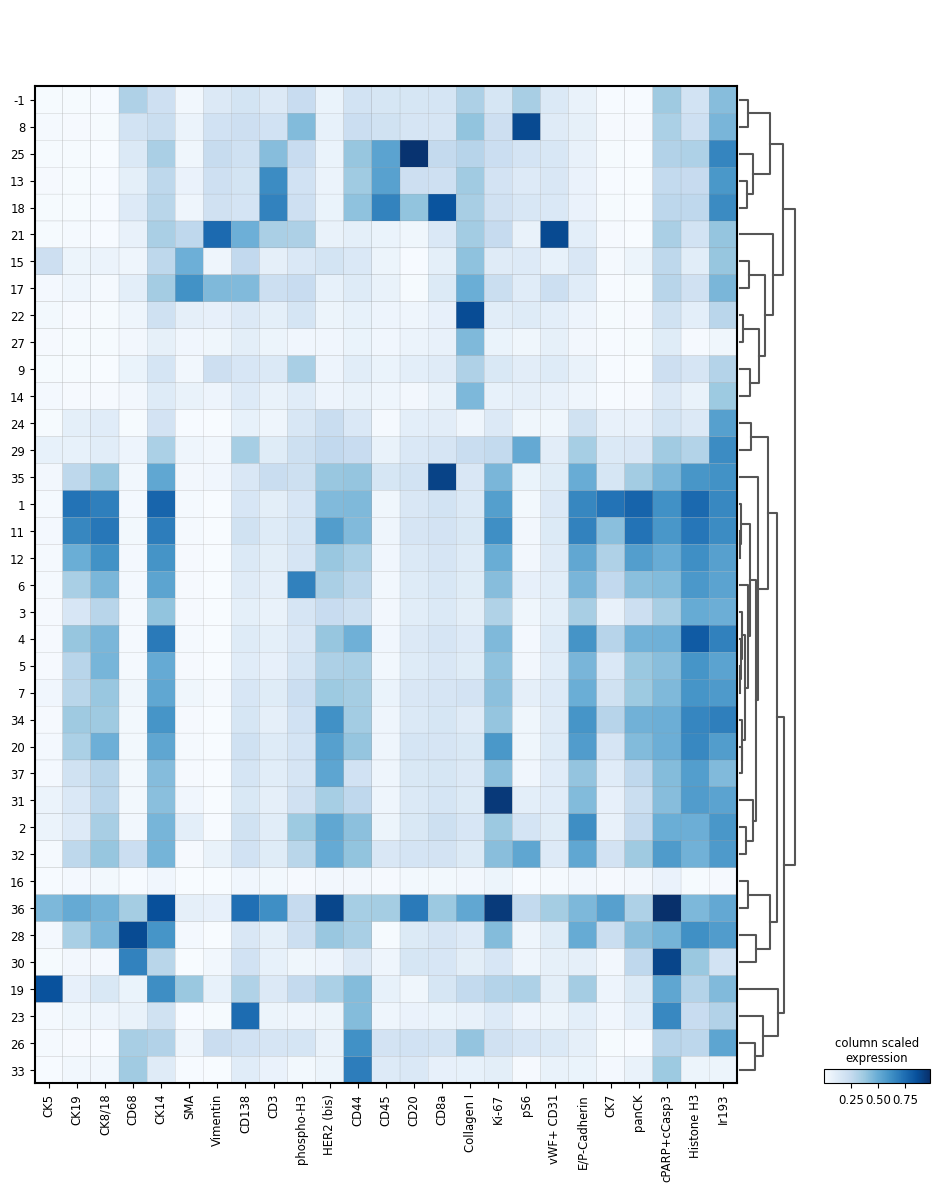

In [24]:
## Re-code labels from here to match the original labels
label_recode = {
    -1:7, 1:3, 2:2, 3:11, 4:12, 5:4, 6:34, 7:1, 8:6, 9:9,
    10:-1, 11:13, 12:14, 13:20, 14:16, 15:22, 16:18, 17:15, 18:19, 19:17,
    20:21, 21:23, 22:8, 23:25, 24:26, 25:27, 26:29, 27:28, 28:24, 29:30,
    30:37, 31:31, 32:32, 33:33, 34:35, 35:36, 36:1, 37:5 }

adata_recoded = adata.copy()
adata_recoded.obs['phenograph'] = adata_recoded.obs['phenograph'].map(label_recode)
adata_recoded.obs['phenograph'] = pd.Categorical(adata_recoded.obs['phenograph'])

# Plot
sc.tl.dendrogram(adata_recoded, groupby='phenograph')
sc.pl.matrixplot(adata_recoded, adata_recoded.var_names, 'phenograph', dendrogram=True, cmap='Blues', 
                 colorbar_title='column scaled\nexpression')

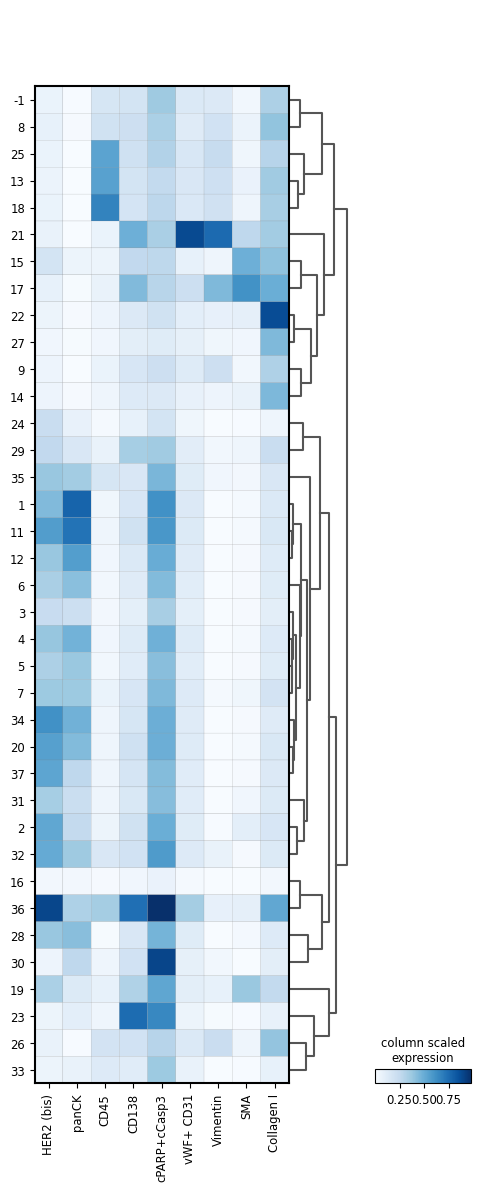

In [25]:
## Plot heatmap using just (informative) cell type markers
ct_markers = ['HER2 (bis)', 'panCK',
              'CD45', 'CD138',
              'cPARP+cCasp3', 'vWF+ CD31', 'Vimentin', 'SMA', 'Collagen I']

adata_recoded.obs['phenograph'] = adata_recoded.obs['phenograph'].astype('category')
sc.tl.dendrogram(adata_recoded, groupby='phenograph')
sc.pl.matrixplot(adata=adata_recoded,
                var_names=ct_markers,
                groupby='phenograph',
                dendrogram=True, cmap='Blues', colorbar_title='column scaled\nexpression')

#### Cancer cells

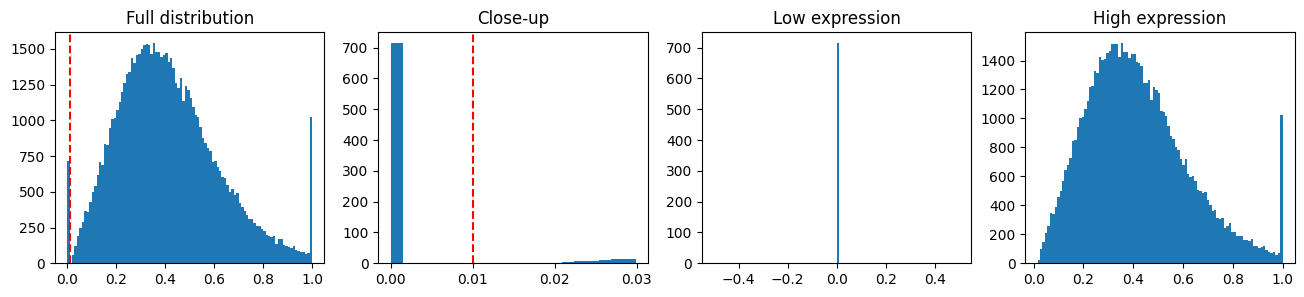

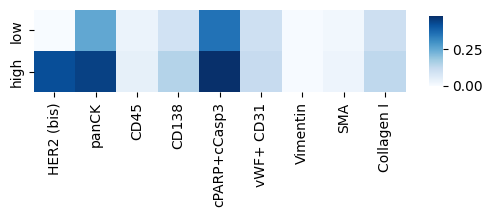

new_label
cancer cell        72596
epithelial cell      714
Name: count, dtype: int64

In [27]:
## Find cutoff value for cancer cells (HER2 if panCK+)
label_subset = [35,1,11,12,6,3,4,5,7,34,20,37,31,2,32,24] # clusters to aggregate
marker = 'HER2 (bis)' # marker to use for thresholding
threshold = 0.01
interval=0.02

# Subset data
expr = adata_recoded.X[ adata_recoded.obs['phenograph'].isin(label_subset), adata_recoded.var_names==marker ]
phenograph_label = adata_recoded.obs['phenograph'][ adata_recoded.obs['phenograph'].isin(label_subset) ]
new_label = (expr>=threshold)*1 ## 0 if below threshold, 1 if >= threshold
cell_ids = adata_recoded.obs.loc[ adata_recoded.obs['phenograph'].isin(label_subset) , 'id' ]

# Plot original, close-up & resulting groups side by side
fig, ax = plt.subplots(1,4, figsize=(16,3))
ax[0].hist(expr, bins=100)
ax[0].axvline(x=threshold, color='r', linestyle='--')
ax[0].set_title('Full distribution')
ax[1].hist(expr[ (expr>=threshold-interval) & (expr<=threshold+interval) ], bins=20)
ax[1].axvline(x=threshold, color='r', linestyle='--')
ax[1].set_title('Close-up')
ax[2].hist(expr[ expr<threshold ], bins=100)
ax[2].set_title('Low expression')
ax[3].hist(expr[ expr>=threshold ], bins=100)
ax[3].set_title('High expression')
plt.show()

# Plot heatmap subset: new grouping, but more/all markers
expr_all = adata_recoded.X[ adata_recoded.obs['phenograph'].isin(label_subset), :]
expr_all0 = expr_all[ new_label==0, : ].mean(axis=0)
expr_all1 = expr_all[ new_label==1, : ].mean(axis=0)
df = pd.DataFrame([expr_all0, expr_all1], index=['low','high'], columns=adata_recoded.var_names)
df = df[ct_markers] ## comment in to show all markers

fig, ax = plt.subplots(figsize=(6,3))
sns.heatmap(ax=ax, data=df, square=True,
            cmap='Blues', cbar_kws={'shrink':.3, 'aspect':5}) #, 'location':'right', 'ticklocation':'right'})
plt.show()

# Create df for recoding
cancer_recoding = pd.DataFrame({'id':cell_ids,'new_label':new_label})
cancer_recoding['new_label'] = cancer_recoding['new_label'].map({0:'epithelial cell', 1:'cancer cell'})
cancer_recoding['new_label'].value_counts()

#### Immune cells
Different immune cell populations could have been distinguished based on the marker panel, but were grouped together due to low overall counts. Nevertheless, some clusters were aggregated and reassign to exclude cells with low expression of characteristic markers.

In [ ]:
## Distinguish macrophages (CD68) from CD68 negative cells
# Export all necessary information to temporary file
# to read into R to use FlowSOM for clustering

outfile = "../../data/temp/Kuett_2022_reclustering_macrophages.csv"
label_subset = [28,30,33,26]

idx = adata_recoded.obs['phenograph'].isin(label_subset)
pd.concat([ pd.DataFrame({'id':adata_recoded.obs['id'][idx],
                          'phenograph':adata_recoded.obs['phenograph'][idx]}).reset_index(drop=True),
            pd.DataFrame(adata_recoded.X[idx, :], columns=adata_recoded.var_names) ],
            axis=1) .to_csv(outfile, index=False)

flowsom
macrophage    1443
unassigned    1142
Name: count, dtype: int64


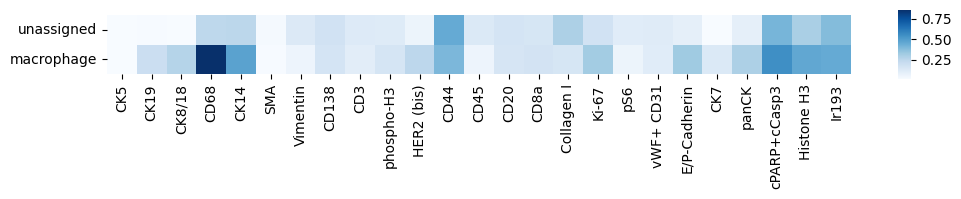

In [36]:
## Get macrophage flowsom clusters
infile = "../../data/temp/Kuett_2022_reclustering_macrophages_flowsom.csv"
macrophage_recoding = pd.read_csv(infile)
macrophage_recoding['flowsom'] = macrophage_recoding['flowsom'].map({'group_1':'macrophage', # cPARP/cCASP3+
                                                                    'group_2':'macrophage', # CD44+
                                                                    'group_3':'macrophage', # HER2/panCK/Cadherin+
                                                                    'unassigned':'unassigned'})
print(macrophage_recoding['flowsom'].value_counts())

# Plot heatmap subset: new grouping, but more/all markers
idx = adata_recoded.obs.reset_index(names='idx').set_index('id').loc[macrophage_recoding['id'], :].reset_index()['idx'].astype(int).values
expr_all = adata_recoded.X[idx, :]
expr_all0 = expr_all[ macrophage_recoding['flowsom']=='unassigned', : ].mean(axis=0)
expr_all1 = expr_all[ macrophage_recoding['flowsom']=='macrophage', : ].mean(axis=0)
df = pd.DataFrame([expr_all0, expr_all1],
                  index=['unassigned', 'macrophage'],
                  columns=adata_recoded.var_names)

fig, ax = plt.subplots(figsize=(12,3))
sns.heatmap(ax=ax, data=df, square=True,
            cmap='Blues', cbar_kws={'shrink':.3, 'aspect':5}) #, 'location':'right', 'ticklocation':'right'})
plt.show()

In [ ]:
## Distinguish plasma cells (CD138)
# Export all necessary information to temporary file
# to read into R to use FlowSOM for clustering

outfile = "../../data/temp/Kuett_2022_reclustering_plasmacells.csv"
label_subset = [19,23,29]

idx = adata_recoded.obs['phenograph'].isin(label_subset)
pd.concat([ pd.DataFrame({'id':adata_recoded.obs['id'][idx],
                          'phenograph':adata_recoded.obs['phenograph'][idx]}).reset_index(drop=True),
            pd.DataFrame(adata_recoded.X[idx, :], columns=adata_recoded.var_names) ],
            axis=1) .to_csv(outfile, index=False)

flowsom
unassigned     3121
plasma cell     811
Name: count, dtype: int64


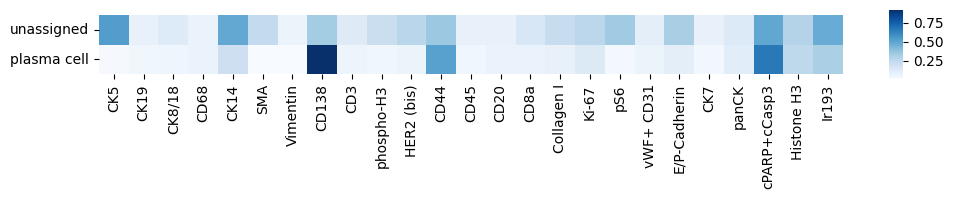

In [ ]:
## Get plasma cell flowsom clusters
infile = "../../data/temp/Kuett_2022_reclustering_plasmacells_flowsom.csv"
plasmacell_recoding = pd.read_csv(infile)
plasmacell_recoding['flowsom'] = plasmacell_recoding['flowsom'].map({'group_1':'plasma cell',
                                                                    'unassigned':'unassigned'})
print(plasmacell_recoding['flowsom'].value_counts())

## Plot heatmap subset: new grouping, but more/all markers
idx = adata_recoded.obs.reset_index(names='idx').set_index('id').loc[plasmacell_recoding['id'], :].reset_index()['idx'].astype(int).values
expr_all = adata_recoded.X[idx, :]
expr_all0 = expr_all[ plasmacell_recoding['flowsom']=='unassigned', : ].mean(axis=0)
expr_all1 = expr_all[ plasmacell_recoding['flowsom']=='plasma cell', : ].mean(axis=0)
df = pd.DataFrame([expr_all0, expr_all1],
                  index=['unassigned', 'plasma cell'],
                  columns=adata_recoded.var_names)

fig, ax = plt.subplots(figsize=(12,3))
sns.heatmap(ax=ax, data=df, square=True,
            cmap='Blues', cbar_kws={'shrink':.3, 'aspect':5}) #, 'location':'right', 'ticklocation':'right'})
plt.show()

#### Final assignments

Notes about clustering:
- -1: According to the [phenograph documentation](https://github.com/jacoblevine/PhenoGraph), "Any rows assigned -1 were identified as outliers and should not be considered as a member of any community"
- 16: Notably low expression on all markers. No phenotype assigned ("other")

In [52]:
## Assign cell types
# Recode all phenograph clusters that are assigned without reclustering
label2description = {-1: "other",
                    1: "",
                    2: "",
                    3: "",
                    4: "",
                    5: "",
                    6: "",
                    7: "",
                    8: "other",
                    9: "other",
                    #10: "", # not present
                    11: "",
                    12: "",
                    13: "immune cell", # also in Kuett et al. (as 'T')
                    14: "stromal cell",
                    15: "myofibroblast",
                    16: "other",
                    17:'myofibroblast',
                    18: "immune cell", # also in Kuett et al. (as 'T')
                    19: "",
                    20: "",
                    21: "endothelial cell", # also in Kuett et al.
                    22:'stromal cell',
                    23: "",
                    24: "",
                    25:'immune cell',
                    26: "",
                    27: "stromal cell",
                    28: "immune cell", # also in Kuett et al. (as macrophage)
                    29: "",
                    30:'immune cell', # also in Kuett et al. (as macrophage)
                    31: "",
                    32: "",
                    33: "",
                    34: "",
                    35: "",
                    36: "apoptotic cell",
                    37: ""}
adata_recoded.obs['ct_broad'] = adata_recoded.obs['phenograph'].map(label2description).astype('category')


# Recode all cells that were reclustered

adata_recoded.obs['ct_broad'] = adata_recoded.obs['ct_broad'].astype(str) ## to add new categories

# Cancer cells
for ct in cancer_recoding['new_label'].unique():
    ids_to_update = cancer_recoding.loc[cancer_recoding['new_label'] == ct, 'id']
    adata_recoded.obs.loc[adata_recoded.obs['id'].isin(ids_to_update), 'ct_broad'] = ct

# Plasma cells
ids_to_update = plasmacell_recoding.loc[plasmacell_recoding['flowsom'] == 'plasma cell', 'id']
adata_recoded.obs.loc[adata_recoded.obs['id'].isin(ids_to_update), 'ct_broad'] = 'plasma cell'

# Macrophages (-> immune cells)
ids_to_update = plasmacell_recoding.loc[plasmacell_recoding['flowsom'] == 'macrophage', 'id']
adata_recoded.obs.loc[adata_recoded.obs['id'].isin(ids_to_update), 'ct_broad'] = 'immune cell'

adata_recoded.obs.loc[ adata_recoded.obs['ct_broad']=='', 'ct_broad' ] = 'other'
adata_recoded.obs['ct_broad'] = adata_recoded.obs['ct_broad'].astype('category')

In [ ]:
## Assign 'invasive objects' as classified by Kuett et al. (2022) to type 'other'
ids_exclude = np.loadtxt('../../data/Kuett_2022/MainHer2BreastCancerModel/invasive_object_list_of_labels', dtype=int, delimiter=',')
adata_recoded[ np.isin(adata_recoded.obs['id'].values, ids_exclude) ].obs['ct_broad'] = 'other'

/tmp/ipykernel_56478/1639233612.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_recoded[ np.isin(adata_recoded.obs['id'].values, ids_exclude) ].obs['ct_broad'] = 'other'


In [54]:
## Show cell type distribution
adata_recoded.obs['ct_broad'].value_counts() / 1000 ## in thousands for readability

ct_broad
cancer cell         72.596
other               15.300
immune cell          7.639
stromal cell         5.981
myofibroblast        3.713
endothelial cell     1.663
plasma cell          0.811
epithelial cell      0.714
apoptotic cell       0.069
Name: count, dtype: float64

#### Combining immune cells to one phenotype

In [57]:
## Merge immune cells 
adata_recoded.obs['ct_broad'] = adata_recoded.obs['ct_fine'].astype(str)

is_immune = np.isin( adata_recoded.obs['ct_broad'].values, ['CD8- T cell', 'CD8+ T cell', 'B cell', 'macrophage A', 'macrophage B', 'macrophage C'] )
adata_recoded.obs.loc[ is_immune, 'ct_broad' ] = 'immune cell'

adata_recoded.obs['ct_broad'] = adata_recoded.obs['ct_broad'].astype('category')

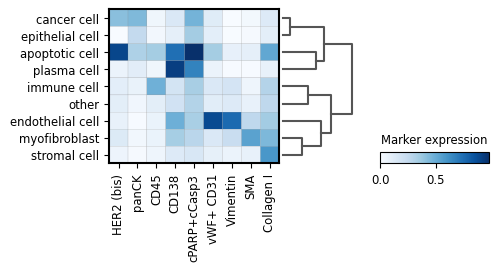

In [ ]:
## Plot heatmap with new cell type labels
sc.tl.dendrogram(adata_recoded, groupby='ct_broad')
sc.pl.matrixplot(adata=adata_recoded,
                var_names=ct_markers,
                groupby='ct_broad',
                figsize=(4.9,2),
                dendrogram=True, 
                cmap='Blues', colorbar_title='Marker expression',
                #save='phenotype_markers_broad.svg'
                )

In [60]:
## Approximate number of cells per 2D section (rough estimate)
np.round( adata_recoded.obs['ct_broad'].value_counts() / 152, 1)

ct_broad
cancer cell         477.6
other               100.4
immune cell          50.5
stromal cell         39.3
myofibroblast        24.4
endothelial cell     10.9
plasma cell           5.3
epithelial cell       4.7
apoptotic cell        0.5
Name: count, dtype: float64

In [ ]:
## Save to file
outfile = '../../data/phenotyping_final_labels.csv'
adata_recoded.obs[['id', 'phenograph', 'ct_broad']].to_csv(outfile, index=False)

In [ ]:
## Save environment specs
!pip freeze > ../../environment/phenotyping.txt